In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as plt_ax
import itertools
%matplotlib inline

def scatter(data, ax=None, enum=False, title='', labels=None, legend=False, colorbar=True, **kwargs):
    axes_defined = ax != None
    if not axes_defined:
        fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    scattered = None
    if enum:
        scattered = ax.scatter(range(len(data)), data, **kwargs)
    else:
        mapping = np.array(data).T
        scattered = ax.scatter(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    if colorbar:
        cax = plt_ax.make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scattered, cax=cax)
        cbar.set_ticks([-1, 0, 1])
    if not axes_defined:
        fig.tight_layout()
    return ax

def plot_function_shape(training_set, method, param_name, params, query_func, resolution=20, stepsRange=3):
    fig, ax = plt.subplots(1, len(params), figsize=(14, 3))
    stepBounds = (0.5 - stepsRange/2, 0.5 + stepsRange/2)
    for i, param in enumerate(params):
        steps = np.arange(*stepBounds, stepsRange / resolution)
        points = np.array(list(itertools.product(reversed(steps), steps)))
        predictions = query_func(training_set, param, points)
        img = ax[i].imshow(predictions.reshape([resolution]*2), extent=[*stepBounds, *stepBounds], cmap='bwr', aspect='auto')
        scatter(training_set, ax[i], c=training_set[:, 2], cmap='bwr', s=30, colorbar=False)
        ax[i].set_ylim(stepBounds)
        ax[i].set_xlim(stepBounds)
        ax[i].set_title(r'{}: ${} = {}$'.format(method, param_name, param))
        ax[i].set_ylabel('x1')
        ax[i].set_xlabel('x2')
    fig.subplots_adjust(wspace=.3)
    cbar = fig.colorbar(img, ax=ax.ravel().tolist())
    cbar.set_ticks([-1, 0, 1])
    return ax

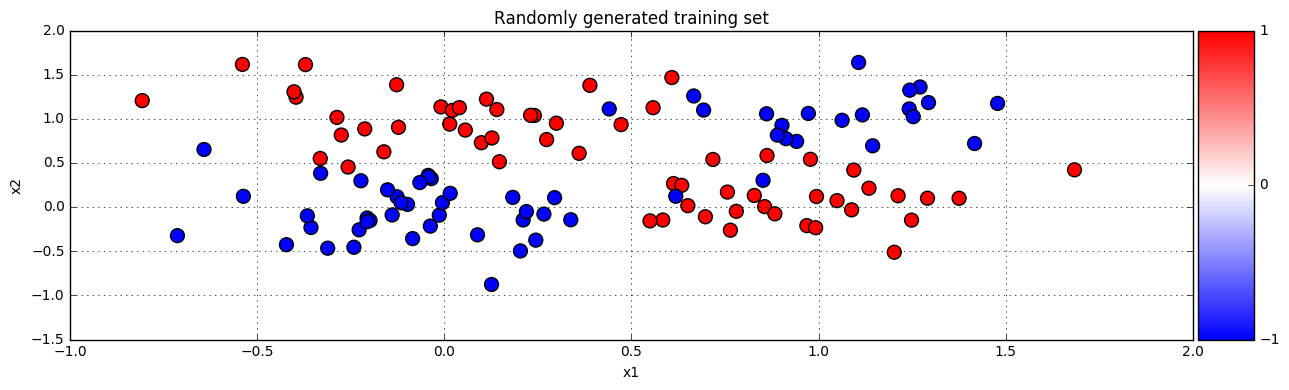

In [3]:
# Exercise 6.1
np.random.seed(0)
def N(mean, variance=0.1, shape=60):
    return np.random.normal(size=[shape, 2], scale=np.sqrt(variance), loc=mean)

def flip_a_coin(dist1, dist2, shape=60):
    choices = np.random.choice([0, 1], shape)
    return np.where(choices, dist1.T, dist2.T).T

datapoints1 = flip_a_coin(N([0, 1]), N([1, 0]))
datapoints2 = flip_a_coin(N([0, 0]), N([1, 1]))
set1 = np.concatenate([datapoints1.T, np.ones((60, 1)).T]).T
set2 = np.concatenate([datapoints2.T, -np.ones((60, 1)).T]).T
training_set = np.concatenate([set1, set2])
_ = scatter(training_set, c=training_set[:, 2], cmap='bwr', s=100, labels=['x1', 'x2'], title='Randomly generated training set')

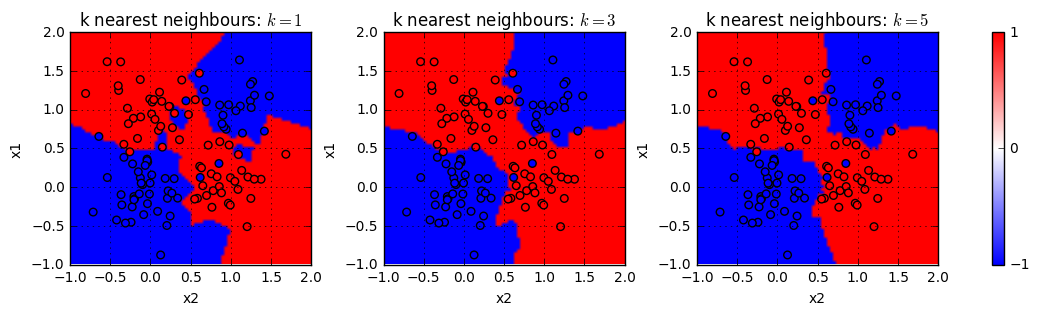

In [11]:
# Exercise 6.2 k nearest neighbours
def query_neighbours(training_set, k, points):
    predictions = np.zeros(points.shape[0])
    for j, point in enumerate(points):
        neighbours = sorted(training_set, key=lambda x: np.linalg.norm(x[:2] - point))
        predictions[j] = np.sign(np.mean(np.array(neighbours)[:k, 2]))
    return predictions

_ = plot_function_shape(training_set, 'k nearest neighbours', 'k', [1, 3, 5], query_neighbours, resolution=80)

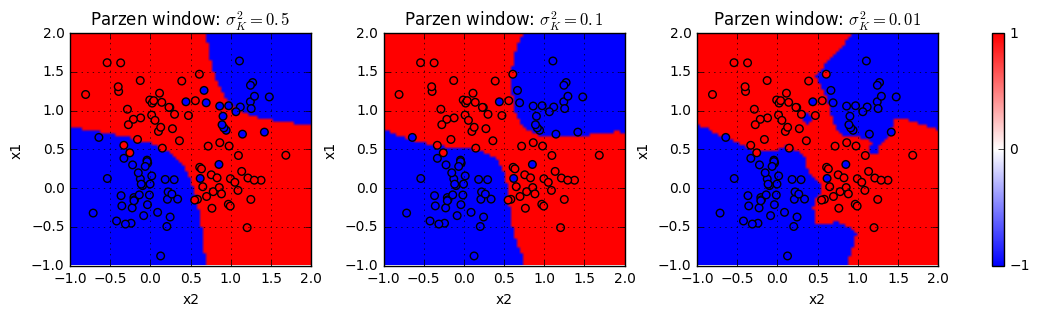

In [13]:
# Exercise 6.3(a) Parzen window
def kernel(x1, x2, variance):
    return np.exp(- (1 / (2 * variance)) * np.linalg.norm(x1 - x2) ** 2)

def kernel_matrix(training_set, points, variance, shape=120):
    shape = (len(points), training_set.shape[0])
    matrix = np.ones(shape)
    for i, j in np.ndindex(shape):
        matrix[i, j] = kernel(points[i], training_set[j, :2], variance)
    return matrix

def query_parzen(training_set, variance, points):
    inputSize = points.shape[0]
    predictions = np.zeros((inputSize, 3))
    output = np.concatenate([points.T, np.zeros((inputSize, 1)).T]).T
    matrix = kernel_matrix(training_set, points, variance)
    for i in range(inputSize):
        for j, p in enumerate(training_set):
            output[i, 2] += matrix[i, j] * p[2]
        output[i, 2] /= matrix[i].sum()
    return np.sign(output[:, 2])

_ = plot_function_shape(training_set, 'Parzen window', '\sigma_K^2', [0.5, 0.1, 0.01], query_parzen, resolution=80)

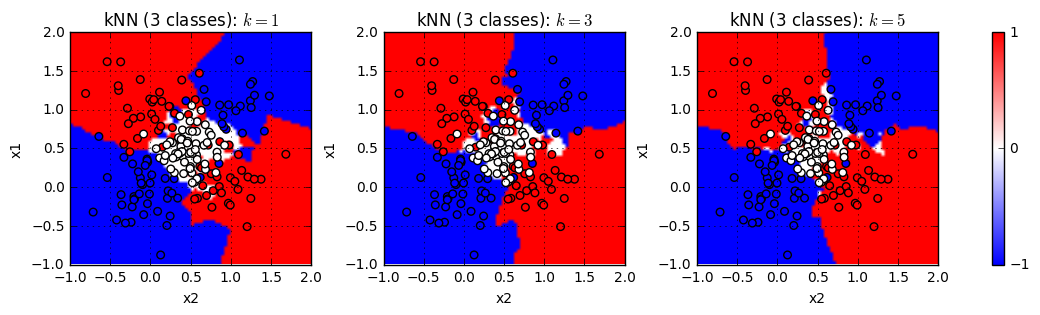

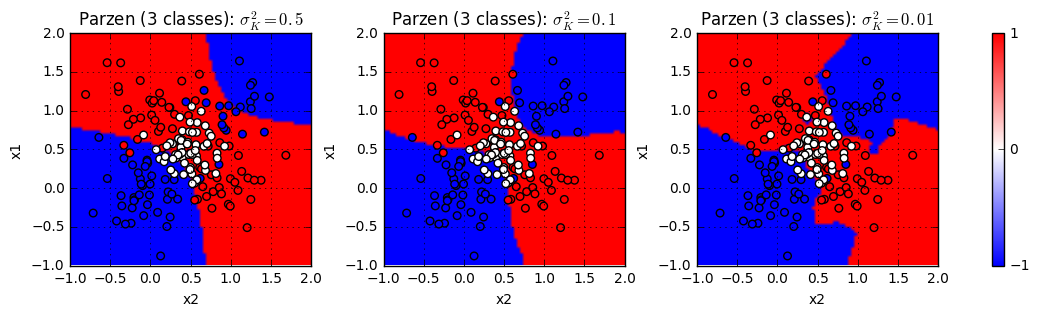

In [14]:
# Exercise 6.3(b): Add third class
set3 = np.concatenate([N([0.5, 0.5], 0.05).T, np.zeros((60, 1)).T]).T
training_set2 = np.concatenate([set1, set2, set3])
_ = plot_function_shape(training_set2, 'kNN (3 classes)', 'k', [1, 3, 5], query_neighbours, resolution=80)
_ = plot_function_shape(training_set2, 'Parzen (3 classes)', '\sigma_K^2', [0.5, 0.1, 0.01], query_parzen, resolution=80)

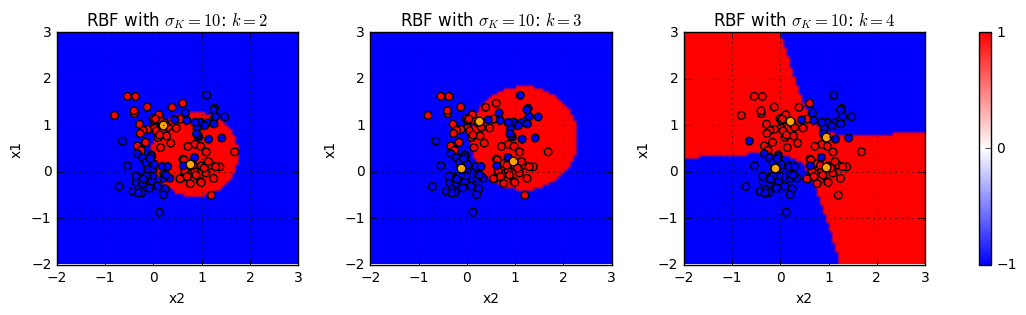

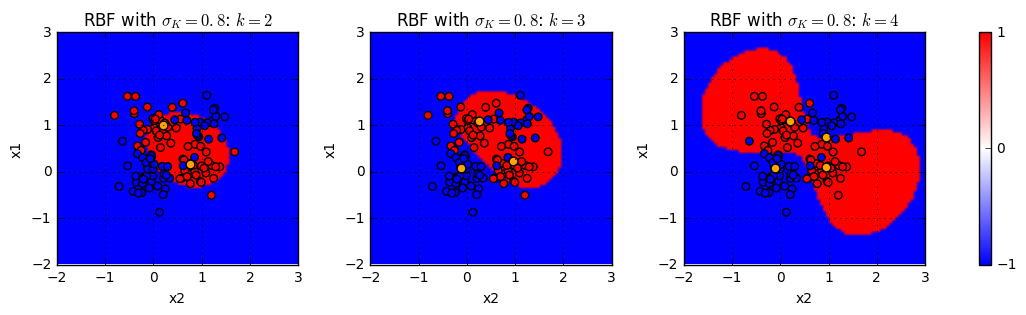

In [15]:
# Exercise 6.4 (a)
def clustering(datapoints, k, eta=0.5, convergences=0.001, epochs=100):
    np.random.seed(42)
    centroids = N([0, 0], variance=0.001, shape=k) + datapoints.mean(axis=0)
    old_centroids = centroids.copy()
    for _ in range(epochs):
        for t, x in enumerate(datapoints):
            nearest = min(range(len(centroids)), key=lambda i: np.linalg.norm(centroids[i] - x))
            centroids[nearest] += (eta / (t + 1)) * (x - centroids[nearest])
        if np.abs(old_centroids - centroids).sum() < convergences:
            return centroids
        old_centroids = centroids.copy()
    return centroids

def Phi(X, k, variance, centroids):
    X = np.array(X)
    _Phi = np.ones((k + 1, X.shape[0]), float)
    for ci, c in enumerate(centroids):
        for xi, x in enumerate(X):
            _Phi[ci + 1, xi] = kernel(x, c, variance)
    return _Phi

def y(X, w, k, variance, centroids, sign=True):
    _Phi = Phi(X, k, variance, centroids)
    if sign:
        return np.sign(w.T.dot(_Phi))
    else:
        return w.T.dot(_Phi)

def rbfnn_train(set_, k, variance, centroids=None):
    centroids = centroids if centroids is not None else clustering(set_[:, :2], k)
    _Phi = Phi(set_[:, :2], k, variance, centroids)
    w = np.linalg.pinv(_Phi).T.dot(set_[:, 2])
    return w, centroids

def query_rbf_variance(variance, sign=True):
    def query_rbf(training_set, k, points):
        w, centroids = rbfnn_train(training_set, k, variance)
        output = y(points, w, k, variance, centroids, sign)
        return output
    return query_rbf

sigmas = [10, 0.8]
ks = [2, 3, 4]
for sigma in sigmas:
    axes = plot_function_shape(training_set, 'RBF with $\sigma_K={}$'.format(sigma),
                             'k', ks, query_rbf_variance(sigma**2),
                             stepsRange=5, resolution=80)
    for i, ax in enumerate(axes.flat):
        centroids = clustering(training_set[:, :2], ks[i])
        scatter(centroids, ax, c='orange', s=40, colorbar=False, title=ax.get_title())

# FIXME: In solution with k=2, sK=0.5 -> "Hyperplane"n

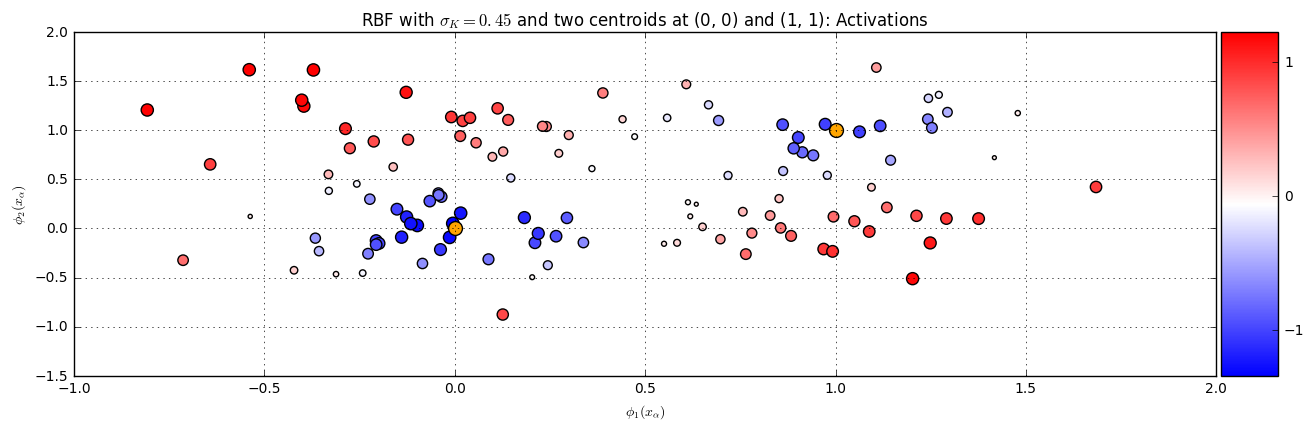

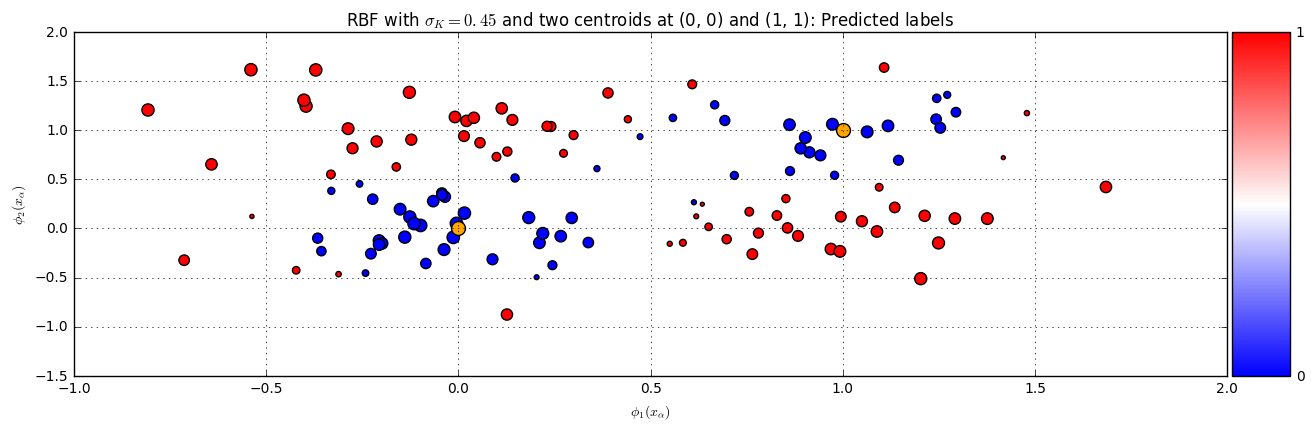

In [8]:
# Exercise 6.4 (b)
centroids = np.array([[0, 0], [1, 1]])
sigma = 0.45
k = 2
w, _ = rbfnn_train(training_set, k, sigma**2, centroids)
output = y(training_set[:,:2], w, k, sigma**2, centroids, sign=False)
ax = scatter(training_set, c=output, cmap='bwr', s=np.sqrt(np.abs(output) * 5000).astype(int))
_ = scatter(centroids, ax, c='orange', colorbar=False, s=100, labels=[r'$\phi_1(x_\alpha)$', r'$\phi_2(x_\alpha)$'],
            title='RBF with $\sigma_K={}$ and two centroids at (0, 0) and (1, 1): Activations'.format(sigma))
ax = scatter(training_set, c=output > 0, cmap='bwr', s=np.sqrt(np.abs(output) * 5000).astype(int))
_ = scatter(centroids, ax, c='orange', colorbar=False, s=100, labels=[r'$\phi_1(x_\alpha)$', r'$\phi_2(x_\alpha)$'],
            title='RBF with $\sigma_K={}$ and two centroids at (0, 0) and (1, 1): Predicted labels'.format(sigma))

# FIXME: Plot distance to the 2 centroid not the coordinates of the datapoints